In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import hspace, qaoa
from scipy.optimize import minimize
from collections import defaultdict
from qiskit import QuantumCircuit, Aer, execute

Let's study the All-to-All 6 qubit ising system

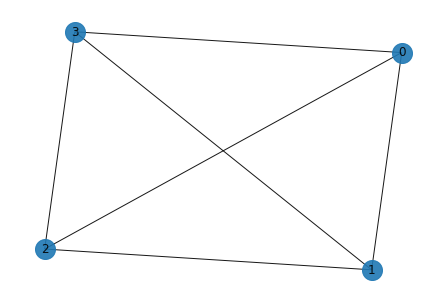

In [17]:
n=4
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(hspace.generate_edges(n))
nx.draw(G,with_labels=True,alpha=0.9,node_size=400)

This system is naturally endowed with a 2^6 dimensional Hilbert space (logical basis), spanned by

In [18]:
logical_basis = hspace.generate_basis(4)

In the LHZ formalism, we want to map the N qubits from the Ising system to the K = N(N-1)/2 Parity variables, and impose C = K - N + 1 holonomy constraints to generate the parity Hilbert space Hpar = H_Ising/Z_2, of dimension 2^(N-1). Let's generate all the canonical constraints and check the matching. First, we can use the `hspace.log_to_phys` function followed by `hspace.remove_duplicates` to map all the logical states in the logical basis to parity states, generating a basis for the physical states

In [19]:
physical_basis = hspace.remove_duplicates([hspace.log_to_phys(state) for state in logical_basis])

In [20]:
physical_basis

[[1, 1, 1, 1, 1, 1],
 [1, 1, 0, 0, 1, 0],
 [1, 0, 0, 1, 0, 1],
 [1, 0, 1, 0, 0, 0],
 [0, 0, 1, 1, 1, 0],
 [0, 0, 0, 0, 1, 1],
 [0, 1, 0, 1, 0, 0],
 [0, 1, 1, 0, 0, 1]]

Notice that the LHZ transform maps the spins to relative spins, naturally generating the quotient of the Z_2 group, i.e dim(H_phys) = dim(H_logical)/dim(Z_2). Next, we can follow another path, namely, we can define a Hilbert space of the K = 15 parity variables, which has an immense overhead, and then impose the C = 10 constraints, separated in 3-body terms (T) and 4-body terms (S).

In [11]:
parity_basis = hspace.generate_basis(15)

In [25]:
len(parity_basis)

32768

In [6]:
T_constraints = hspace.generate_T_constraints(n)
S_constraints = hspace.generate_S_constraints(n)

The complete set of holonomies (https://www.science.org/doi/epdf/10.1126/sciadv.1500838) are generated by four 3-body interactions, and six 4-body interactions

In [7]:
T_constraints

[[(0, 1), (0, 2), (1, 2)],
 [(1, 2), (1, 3), (2, 3)],
 [(2, 3), (2, 4), (3, 4)],
 [(3, 4), (3, 5), (4, 5)]]

In [8]:
S_constraints

[[(0, 2), (1, 2), (0, 3), (1, 3)],
 [(0, 3), (1, 3), (0, 4), (1, 4)],
 [(1, 3), (2, 3), (1, 4), (2, 4)],
 [(0, 4), (1, 4), (0, 5), (1, 5)],
 [(1, 4), (2, 4), (1, 5), (2, 5)],
 [(2, 4), (3, 4), (2, 5), (3, 5)]]

The sanity check requires us to follow the constraints (even number of 0's in each Holonomy state) t eliminate spurous states from the parity basis. We can use the functions `hspace.k-body_fix` to eliminate the states. But first we need to map the space of edges to the space of physical qubits, via the function `hspace.to_parity_basis`

In [9]:
T_list = [hspace.to_parity_basis(T,n) for T in T_constraints]
S_list = [hspace.to_parity_basis(S,n) for S in S_constraints]

In [12]:
for T in T_list:
    parity_basis = hspace.k_body_fix(T,parity_basis)[1]
for S in S_list:
    parity_basis = hspace.k_body_fix(S,parity_basis)[1]

Which imposes the constraints, generating the parity basis:

In [34]:
parity_basis

[[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
 [0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
 [0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
 [0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1],
 [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
 [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0],
 [0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
 [0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1],
 [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
 [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
 [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0],
 [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [35]:
len(parity_basis)

32

In [13]:
physical_basis.sort()
parity_basis.sort()

In [16]:
parity_basis == physical_basis

True